In [1]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from sklearn import datasets
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'GPyOpt'

In [ ]:
data = pd.read_csv("YS01 - Test Data.csv")
print(data.shape)

(103, 13)


In [ ]:
catalyst_encoder = LabelEncoder()
scavenger_encoder = LabelEncoder()

data.drop(['Index'],axis=1,inplace=True)
data.drop(['QDs'],axis=1,inplace=True)

data['Catalyst'] = catalyst_encoder.fit_transform(data['Catalyst'])
label_mapping = dict(zip(catalyst_encoder.classes_, catalyst_encoder.transform(catalyst_encoder.classes_)))
print(label_mapping)
data['Hole Scavengar'] = scavenger_encoder.fit_transform(data['Hole Scavengar'])
label_mapping = dict(zip(scavenger_encoder.classes_, scavenger_encoder.transform(scavenger_encoder.classes_)))
print(label_mapping)

# data['H2 Area'] = data['H2 Area'] / data['Time ']
# data['CH4 Area'] = data['CH4 Area'] / data['Time ']
# data['CO Area'] = data['CO Area'] / data['Time ']

# data.drop(['Time '],axis=1,inplace=True)

data = data.fillna(0)

features_scaler = StandardScaler()
target_scaler = StandardScaler()

data_pipeline = Pipeline([
        ('std_scaler', features_scaler),
    ])

target_pipeline = Pipeline([
        ('std_scaler', target_scaler),
    ])

target = data['CO Area']
features = data.drop('CO Area', axis=1)

columns_f = features.columns

# features = data_pipeline.fit_transform(features)
# features = pd.DataFrame(features,columns=columns_f)

# target = data_pipeline.fit_transform(target.to_numpy().reshape(-1,1))
# target = pd.DataFrame(target,columns=['CO Area'])


{'Co-TPP-COOH4': 0, 'CoCl2': 1, 'FeCl2': 2, 'FeCl3': 3, 'MnCl2': 4, 'ZnAc2': 5, 'ZnCl2': 6, nan: 7}
{'NaAsc': 0, nan: 1}


In [ ]:
x_train, X_test, y_train, Y_test = train_test_split(features, target, test_size=0.05, random_state=42)

In [ ]:
def objective_function(params):
    model = xgb.XGBRegressor(objective='reg:squarederror', params = params[0])
    scores = cross_val_score(model, x_train, y_train, cv=5)
    return -scores.mean()

In [ ]:
bounds = [
    {'name': 'Catalyst', 'type': 'categorical', 'domain': [0,1,2,3,4,5,6]},
    {'name': 'Hole Scavenger (mM)', 'type': 'continuous', 'domain': (0, 1000)},
    {'name': 'Catalyst amount (umol)', 'type': 'continuous', 'domain': (0, 2000)},
    {'name': 'QD amount (umol)', 'type': 'continuous', 'domain': (0, 1000)},
    {'name': 'pH before', 'type': 'continuous', 'domain': (0, 14)},
    {'name': 'C', 'type': 'continuous', 'domain': (0.1, 10)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0.0001, 1)}
]

In [ ]:
optimizer = BayesianOptimization(f=objective_function, domain=bounds)

In [ ]:
optimizer.run_optimization(max_iter=50)

In [ ]:
optimized_params = optimizer.X[np.argmin(optimizer.Y)]
optimized_score = -np.min(optimizer.Y)

print(f"Catalyst: = {optimized_params[0]}, Hole Scavenger (mM): = {optimized_params[1]}, Catalyst Amount (umol): = {optimized_params[2]}")
print(f"QD amount (umol): = {optimized_params[3]}, pH before: = {optimized_params[4]}")
print(f"C: = {optimized_params[5]}, gamma: = {optimized_params[6]}")
print(f"Best cross-validated accuracy: {optimized_score}")

Catalyst: = 4.0, Hole Scavenger (mM): = 537.4777820695807, Catalyst Amount (umol): = 1964.996423258957
QD amount (umol): = 866.0137929155065, pH before: = 12.53865504206081
C: = 2.0872935662802425, gamma: = 0.04555342882301547
Best cross-validated accuracy: 0.6928657256444054


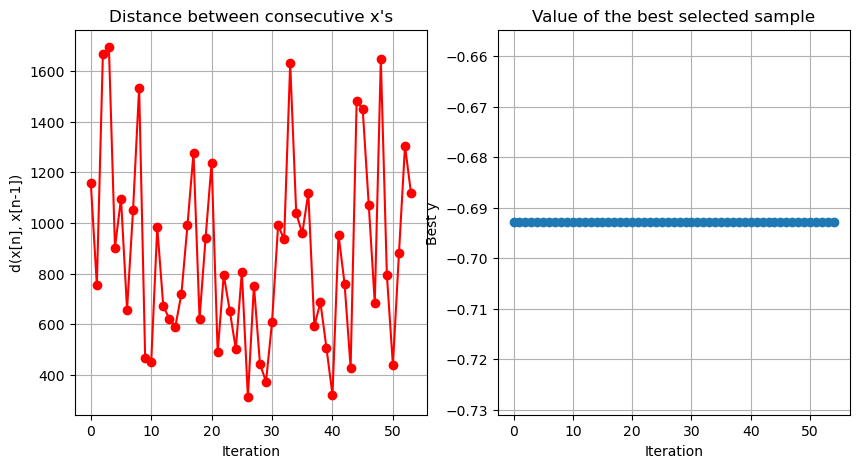

In [ ]:
optimizer.plot_convergence()